In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.io import readsav
from scipy import interpolate

plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)



In [2]:
PSB_savfile = '/data/astro/PSBs/PSB_EAGLE_properties_Davis19.sav'
wilkinson_data = '/data/astro/PSBs/Wilkinson_withMstar.csv'

In [5]:
content = readsav(PSB_savfile, python_dict=True, )
# zdrop seems to be lookbacktime!!
content['lbt_drop'] = content.pop('zdrop')

In [6]:
# two little convenience functions
z_to_lbt = interpolate.interp1d(content['redshift_mt'], content['lbt_mt'], kind='linear')
lbt_to_z = interpolate.interp1d(content['lbt_mt'], content['redshift_mt'], kind='linear')


In [7]:
# So what's in there? Check in Explore_Davis_PSBs

## Some data prep

Galaxies are a PSB from lbt_drop until 600 Myr later, so that gives us a range of points along the history of each galaxy in which it is considered PSB. Here, we collect a data set that repeats the same galaxy often, so we can sample from it to get different evolutionary stages. Note that the 201 time steps are not equally spaced.

In [8]:
todf = ['subgal_thatdropped', 'gal_thatdropped', 'dropsize', 'halosmass_at_drop', 'stellarmass_at_drop', 'nearest_halo_rvir', 
        'sub_atdrop', 'n_10mpc', 'rho_10mpc', 'sigma_10mpc', 'n_5mpc', 'rho_5mpc', 'sigma_5mpc', 'psb_topleaf', 'psb_lastmerger_time',
        'psb_lastmerger_mass_ratio', 'psb_bh_acc_rate', 'lbt_drop']
psb = pd.DataFrame()
for col in todf:
    psb[col] = np.array(content[col], '<f8') # dtype specification to circumvent endian-issues in DataFrame

psb['lbt_end'] = np.array(psb.lbt_drop - 0.6, '<f8')
psb['z_drop'] = lbt_to_z(psb.lbt_drop)
psb['z_end'] = lbt_to_z(psb.lbt_end)

psb['min_hist_ind'] = [np.argmax((a - np.array(content['lbt_mt'], '<f8')) > 0) for a in psb.lbt_drop]
psb['max_hist_ind'] = [np.argmax((a - np.array(content['lbt_mt'], '<f8')) > 0) for a in psb.lbt_end]
psb['n_points_hist'] = psb.max_hist_ind - psb.min_hist_ind

In [9]:
psb.head()

,subgal_thatdropped,gal_thatdropped,dropsize,halosmass_at_drop,stellarmass_at_drop,nearest_halo_rvir,sub_atdrop,n_10mpc,rho_10mpc,sigma_10mpc,...,psb_lastmerger_time,psb_lastmerger_mass_ratio,psb_bh_acc_rate,lbt_drop,lbt_end,z_drop,z_end,min_hist_ind,max_hist_ind,n_points_hist
0,9.0,1.0,10.538650,2.435624e+12,6.482576e+10,0.001984,9.0,363.0,10.427334,0.559907,...,0.000000,0.004499,0.001812,6.9,6.3,0.775044,0.667511,144,149,5
1,11.0,1.0,10.360600,1.407677e+12,4.015368e+10,0.000000,11.0,140.0,10.185263,0.146128,...,0.140931,0.001152,0.000174,9.6,9.0,1.530074,1.305111,115,123,8
2,12.0,1.0,8.270670,2.495822e+12,4.891523e+10,0.028870,12.0,281.0,10.454709,0.448706,...,0.420128,0.105064,0.000209,5.7,5.1,0.572348,0.487256,154,159,5
3,18.0,1.0,21.556122,1.186061e+12,5.174523e+10,1.161403,18.0,270.0,10.403675,0.431364,...,0.150798,0.005406,0.000559,4.8,4.2,0.447902,0.374720,161,166,5
4,22.0,1.0,7.393129,9.565876e+11,2.310863e+10,1.971296,22.0,469.0,10.528713,0.671173,...,0.174659,0.000250,0.003645,6.3,5.7,0.667511,0.572348,149,154,5


<AxesSubplot:>

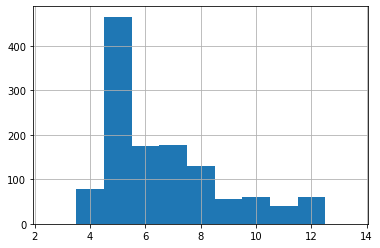

In [10]:
psb.n_points_hist.hist(bins=np.arange(3, 15)-0.5)

## Evolution through PSB phase

Construct a DataFrame for all PSBs that describes their evolution in 100 timesteps from 1Gyr before lbt_drop to 1 Gyr after. This requires interpolation of the shape(201, 1244) arrays in the data. The result is a DataFrame with 1244 * 100 rows. The timeslots within the PSB window (lbt_drop to 600 Myr later) are indicated by flag_PSB.

In [11]:
ntimes = 20
timesteps = np.linspace(0, -0.6, ntimes)
mt_hist = np.array(content['lbt_mt'], '<f8')

In [12]:
# Interpolation convenience function
def intpol(quant, igal):
    return interpolate.interp1d(mt_hist, content[quant][:,igal], kind='linear')

In [13]:
PSB_hist = pd.DataFrame()
columns = ['psb_mhalo', 'psb_mgas_all', 'psb_halfmassrad', 'psb_mgas_sf_30', 'psb_mstar_30', 'psb_sfr_30']

for igal in range(1244):
    thisgal = pd.DataFrame()
    times = psb.lbt_drop[igal] + timesteps
    thisgal['PSB_index'] = [igal for i in range(ntimes)]
    thisgal['LBT'] = times
    thisgal['t-t_burst'] = -1. * timesteps
    
    for c in columns:
        thisgal[c] = intpol(c, igal)(times)
    
    PSB_hist = PSB_hist.append(thisgal)
PSB_hist.reset_index(inplace=True)
PSB_hist['z'] = lbt_to_z(PSB_hist.LBT)
PSB_hist['log_Mstar'] = np.log10(PSB_hist.psb_mstar_30)
PSB_hist['log_Mhalo'] = np.log10(PSB_hist.psb_mhalo)


/home/marcel/anaconda3/envs/astro/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/marcel/anaconda3/envs/astro/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [14]:
PSB_hist.shape

(24880, 13)

In [15]:
PSB_hist.head(30)

,index,PSB_index,LBT,t-t_burst,psb_mhalo,psb_mgas_all,psb_halfmassrad,psb_mgas_sf_30,psb_mstar_30,psb_sfr_30,z,log_Mstar,log_Mhalo
0,0,0,6.900000,-0.000000,2.435624e+12,9.452676e+09,6.614004,4.747499e+09,5.500138e+10,2.032191,0.775044,10.740374,12.386610
1,1,0,6.868421,0.031579,2.472706e+12,1.001542e+10,6.620931,5.354312e+09,5.503569e+10,2.323291,0.769002,10.740644,12.393172
2,2,0,6.836842,0.063158,2.539496e+12,1.046567e+10,6.646756,5.571472e+09,5.509139e+10,2.522888,0.763078,10.741084,12.404748
3,3,0,6.805263,0.094737,2.606286e+12,1.091591e+10,6.672581,5.788632e+09,5.514710e+10,2.722486,0.757154,10.741523,12.416022
4,4,0,6.773684,0.126316,2.673077e+12,1.136616e+10,6.698407,6.005792e+09,5.520281e+10,2.922084,0.751230,10.741961,12.427011
5,5,0,6.742105,0.157895,2.807068e+12,1.164564e+10,6.708403,6.258771e+09,5.523877e+10,18.678468,0.745396,10.742244,12.448253
6,6,0,6.710526,0.189474,2.981875e+12,1.182141e+10,6.708787,6.533504e+09,5.526274e+10,43.883228,0.739618,10.742432,12.474489
7,7,0,6.678947,0.221053,3.156681e+12,1.199719e+10,6.709170,6.808238e+09,5.528671e+10,69.087988,0.733839,10.742621,12.499231
8,8,0,6.647369,0.252632,3.331488e+12,1.217296e+10,6.709554,7.082972e+09,5.531068e+10,94.292747,0.728060,10.742809,12.522638
9,9,0,6.615790,0.284211,3.374641e+12,1.250384e+10,6.724649,7.090080e+09,5.533849e+10,69.779877,0.722421,10.743027,12.528228


In [16]:
# Moster, Naab, White 2013 stellar-to-halo mass relation
M10 = 11.59
M11 = 1.195
N10 = 0.0351
N11 = -0.0247
b10 = 1.376
b11 = -0.826
g10 = 0.608
g11 = 0.329

logM1z = lambda z: M10 + M11 * (z / (1+z))
Nz = lambda z: N10 + N11 * (z / (1+z))
bz = lambda z: b10 + b11 * (z / (1+z))
gz = lambda z: g10 + g11 * (z / (1+z))

MstarMhalo = lambda mhalo, z: mhalo * 2 * Nz(z) * ( (mhalo / 10**(logM1z(z)))**(-1*bz(z)) + (mhalo / 10**(logM1z(z)))**(gz(z)) )**-1

In [17]:
# Read Wilkinson observational results
wilkinson = pd.read_csv(wilkinson_data)

wilkinson.head(20)

,Unnamed: 0,survey,z_min,z_max,Mstar_min,Mstar_max,N,sum_weight,b,sigma_b,M_halo,M_halodn,M_haloup,Mstar
0,0,UDS,0.5,1.0,9.0,9.5,234,200.17,4.94,0.68,14.4,14.2,14.5,9.215858
1,1,UDS,0.5,1.0,9.5,10.0,69,58.64,3.10,1.00,13.8,13.3,14.2,9.695434
2,2,UDS,0.5,1.0,10.0,10.5,44,36.55,1.06,0.93,11.8,8.4,13.2,10.255309
3,3,UDS,1.0,1.5,9.5,10.0,179,112.82,4.96,0.88,14.0,13.8,14.2,9.755501
4,4,UDS,1.0,1.5,10.0,10.5,202,146.70,1.70,0.63,12.4,11.2,13.0,10.224984
5,5,UDS,1.0,1.5,10.5,12.0,136,105.27,1.87,0.74,12.6,11.4,13.1,10.736560
6,6,UDS,1.5,2.0,10.0,10.5,144,125.05,3.73,0.74,13.3,13.0,13.5,10.259956
7,7,UDS,1.5,2.0,10.5,12.0,178,158.10,2.44,0.61,12.6,12.1,13.0,10.776489
8,8,UDS,2.0,2.5,10.0,10.5,167,84.64,4.74,1.32,13.3,12.8,13.6,10.242041
9,9,UDS,2.0,2.5,10.5,12.0,154,97.38,2.19,0.92,12.0,10.7,12.7,10.775278


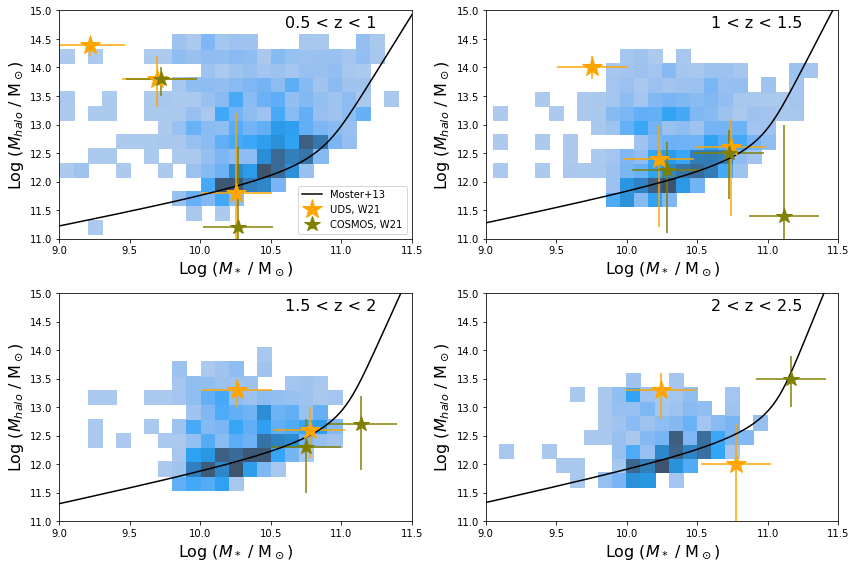

In [20]:
# In bins of redshift, plot bins of Mstar-Mhalo
zlims = [0.5, 1, 1.5, 2, 2.5]

plt.figure(figsize=(12,8))

for iz, z in enumerate(zlims[:-1]):
#     print(f'Running for z={z}')
    ax = plt.subplot(2, 2, iz+1)
    
    # Moster et al 2013 Mhalo-Mstar relation (centrals!), see above
    lMhaloM = np.linspace(11,15, 200)
    MhaloM = 10**(lMhaloM)
    zM = (z + zlims[iz+1])/2
    lMstarM = np.log10(MstarMhalo(MhaloM, zM))
    
    #PSBs
    psbs = PSB_hist[((PSB_hist.z > z) & (PSB_hist.z < zlims[iz+1]))]
    psbs['binnr'] = np.floor((psbs.log_Mstar - 9)/0.25)
    psbs = psbs[psbs.binnr >= 0]
    
    # Binned values
    binned = psbs.groupby('binnr')
    Mstar = binned.log_Mstar.mean()
    Mhalo = binned.log_Mhalo.mean()
    Mhalo_std = binned.log_Mhalo.std()
    
    # Wilkinson observational values
    UDS = wilkinson[((wilkinson.survey == "UDS") & (wilkinson.z_min == z) & (wilkinson.z_max == zlims[iz+1]))]
    cosmos = wilkinson[((wilkinson.survey == "COSMOS") & (wilkinson.z_min == z) & (wilkinson.z_max == zlims[iz+1]))]

    
    # Plot!
    sns.histplot(psbs, x='log_Mstar', y='log_Mhalo', binwidth=[0.1, 0.25])
#     plt.errorbar(Mstar.values, Mhalo.values, yerr=Mhalo_std.values, color='olive', linewidth=3)
    plt.plot(lMstarM, lMhaloM, color='black', label="Moster+13")
    
    plt.errorbar(UDS.Mstar.values, UDS.M_halo.values, 
                 xerr=0.25, yerr=np.array(list(zip(UDS.M_halo - UDS.M_halodn, UDS.M_haloup - UDS.M_halo))).T,
                 fmt='*', markersize=20, color='orange', label='UDS, W21')
    plt.errorbar(cosmos.Mstar.values, cosmos.M_halo.values, 
                 xerr=0.25, yerr=np.array(list(zip(cosmos.M_halo - cosmos.M_halodn, cosmos.M_haloup - cosmos.M_halo))).T,
                 fmt='*', markersize=16, color='olive', label='COSMOS, W21')
    
    plt.xlim([9, 11.5])
    plt.ylim([11, 15])
    plt.text(10.6, 14.7, f'{z} < z < {zlims[iz+1]}', fontsize=16)
    plt.xlabel("Log ($M_*$ / M$_\odot$)", fontsize=16)
    plt.ylabel("Log ($M_{halo}$ / M$_\odot$)", fontsize=16)
    if iz == 0:
        plt.legend(loc='lower right')
plt.tight_layout()
# plt.savefig('output/MstarMhalo.png', dpi=300)

Text(0, 0.5, 'N')

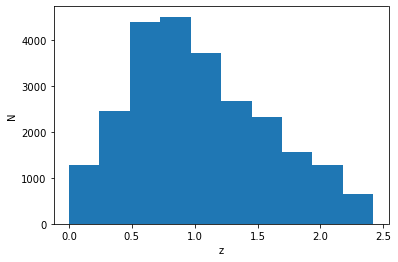

In [19]:
plt.hist(PSB_hist.z)
plt.xlabel('z')
plt.ylabel('N')
# plt.savefig('output/Redshift_histogram.png')